## Set up Dataset

In [1]:
import datasets as datasets
import models as models
import losses as losses
import utils
import config as cf
import torch

import pickle
import os

config = cf.read_json("../experiments/exp_r4_linear_output/triplet_ge_first/config.json")
config['exp_dir'] = os.path.join(config["trainer"]["base_exp_dir"], config["model_name"])
torch.cuda.set_device(config['device_num'])

# Load Train Dataset
if "precomputed_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["precomputed_train"], "rb"))
elif "save_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["save_train"], "rb"))
else:
    train_dataset = cf.initialize_from_config(config, 'dataset', datasets)

#if "precomputed_val" in config['dataset']:
#    val_dataset = pickle.load(open(config['dataset']["precomputed_val"], "rb"))
#elif "save_val" in config['dataset']:
#    val_dataset = pickle.load(open(config['dataset']["save_val"], "rb"))
#else:
val_dataset = cf.initialize_from_config(config, 'dataset', datasets, split="test")

train_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, train_dataset, shuffle=True)
val_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, val_dataset)

# Wrappers for embedding evaluation
ge_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, train_dataset)
ge_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, val_dataset)
smiles_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, train_dataset)
smiles_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, val_dataset)

uniq_train_perts = set(smiles_wrapper_train.pert_smiles)
uniq_val_perts = set(smiles_wrapper_val.pert_smiles)

ge_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_train)
ge_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_val)
smiles_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_train)
smiles_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_val)

### Load Model

In [2]:
import torch
import torch.nn as nn
import sys

model = torch.load("../experiments/exp_r3_act_embed/triplet_ge_first/checkpoint_triplet_ge_first_95_val_mrr=0.08731826.pth")

/home/anaconda/anaconda3/envs/siamese/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.FeedForwardTripletNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/anaconda/anaconda3/envs/siamese/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.SNN_Embedder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [3]:
chemprop_model_pretrained = models.load_chemprop_model("/home/sgf2/DBMI_server/repo/chemprop/pcba/model_unoptimized.pt")

In [4]:
import numpy as np

def get_embeddings(model, ge_wrapper, ge_loader, smiles_wrapper, smiles_loader):
    gex_raw = np.zeros([ge_wrapper.__len__(), ge_wrapper.__getitem__(0)[0].shape[0]])
    gex_embeddings = np.zeros([ge_wrapper.__len__(), model.embed_size])
    smiles_gex_labels = []
    smiles_chem_labels = []
    chem_embeddings = np.zeros([smiles_wrapper.__len__(), model.embed_size])
    
    if 'rdkit_features' in config and config['rdkit_features']:
        nfeats_chemprop = 2400
    else:
        nfeats_chemprop = 300
    chem_embeddings_chemprop = np.zeros([smiles_wrapper.__len__(), nfeats_chemprop])
    # smiles_strings = smiles_wrapper.pert_smiles

    model.eval()
    with torch.no_grad():
        # GE embeds for all of train
        for i, batch in enumerate(ge_loader):
            gex = batch[0].cuda()
            start_ind = i * ge_loader.batch_size
            end_ind = start_ind + gex.shape[0]

            smiles_gex_labels.extend(batch[1])
            gex_embeddings[start_ind:end_ind, :] = model.ge_embed(gex).cpu().numpy()
            gex_raw[start_ind:end_ind, :] = gex.cpu().numpy()

        # Embeds for all unique chems
        for i, batch in enumerate(smiles_loader):
            smiles = batch
            smiles_chem_labels.extend(batch)
            start_ind = i * smiles_loader.batch_size
            end_ind = start_ind + len(smiles)
            if 'rdkit_features' in config and config['rdkit_features']:
                feats = [smiles_to_feats[x] for x in smiles]
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles, feats))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles, feats)
            else:
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles)
            chem_embeddings[start_ind:end_ind, :] = chem_embeds.cpu().numpy()
            chem_embeddings_chemprop[start_ind:end_ind, :] = chem_embeds_chemprop.cpu().numpy()
            
    # Embeddings for all chems in train
    smile_to_chem = {}
    smile_to_chem_cp = {}
    for i, smile in enumerate(smiles_chem_labels):
        smile_to_chem[smile] = chem_embeddings[i,:]
        smile_to_chem_cp[smile] = chem_embeddings_chemprop[i,:]

    chem_embeddings_all = []
    chem_embeddings_all_chemprop = []
    for smile in smiles_gex_labels:
        chem_embeddings_all.append(smile_to_chem[smile])
        chem_embeddings_all_chemprop.append(smile_to_chem_cp[smile])
    chem_embeddings_all = np.stack(chem_embeddings_all)
    chem_embeddings_all_chemprop = np.stack(chem_embeddings_all_chemprop)

    return gex_raw, gex_embeddings, chem_embeddings_all, chem_embeddings_all_chemprop, np.array(smiles_gex_labels), np.array(smiles_chem_labels)

In [5]:
gex_raw, gex_embeddings, chem_embeddings, chem_embeddings_chemprop, smiles_gex_labels, smiles_chem_labels = get_embeddings(model, ge_wrapper_val, ge_loader_val, smiles_wrapper_val, smiles_loader_val)
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_chemprop.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((5069, 2934), (5069, 128), (5069, 128), (5069, 300), 5069, 3370)

In [6]:
gex_raw_train, gex_embeddings_train, chem_embeddings_train, chem_embeddings_chemprop_train, smiles_gex_labels_train, smiles_chem_labels_train = get_embeddings(model, ge_wrapper_train, ge_loader_train, smiles_wrapper_train, smiles_loader_train)
gex_raw_train.shape, gex_embeddings_train.shape, chem_embeddings_train.shape, chem_embeddings_chemprop_train.shape, len(smiles_gex_labels_train), len(smiles_chem_labels_train)

((29548, 2934), (29548, 128), (29548, 128), (29548, 300), 29548, 6318)

# Distance Computations

## Model space

In [ ]:
from scipy.spatial.distance import cdist
gex_chem_embed_dist = cdist(gex_embeddings_mean_pd, chem_embeddings_mean_pd,  metric='correlation')

gex_chem_dists = gex_chem_embed_dist[np.triu_indices(2248, k=1)]

gex_chem_embed_dist.shape, len(gex_chem_dists)

In [ ]:
import seaborn as sns
sns.distplot(gex_chem_embed_dist.diagonal())
sns.distplot(gex_chem_embed_dist[np.triu_indices(2248, k=1)])

In [ ]:
print("Average correlation between matched GE and Chem embeds:   ", np.mean(1 - gex_chem_embed_dist.diagonal()))
print("Average correlation between unmatched GE and Chem embeds: ", np.mean(1 - gex_chem_embed_dist[np.triu_indices(2248, k=1)]))


## Tanimoto similarity

In [15]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MolFromSmiles,AllChem
ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fps = [FingerprintMols.FingerprintMol(x) for x in ms]

In [16]:
inds = np.triu_indices(2248, k=1)
tanimoto_dists = [1 - DataStructs.FingerprintSimilarity(fps[inds[0][i]],
                                   fps[inds[1][i]])
 for i in range( len(inds[0]) )
]

In [17]:
ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fingerprints = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms])

ms_train = [MolFromSmiles(x) for x in smiles_gex_labels_train]
fingerprints_train = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms_train])

fingerprints.shape, fingerprints_train.shape

((5069, 128), (29548, 128))

## GE similarity 

In [ ]:
gex_raw_pd = pd.DataFrame(data=gex_raw[:,-978:], index = smiles_gex_labels).rename_axis(index=['smiles'])
gex_raw_train_pd = pd.DataFrame(data=gex_raw_train[:,-978:], index = smiles_gex_labels_train).rename_axis(index=['smiles'])

In [ ]:
average_ges = gex_raw_pd.groupby('smiles').mean()
ge_dists = cdist(average_ges,average_ges, "correlation")[np.triu_indices(2248,k=1)]

In [ ]:
len(tanimoto_dists),len(gex_chem_dists),len(ge_dists)

## Correlations of Distances

In [ ]:
(np.corrcoef(tanimoto_dists, ge_dists)[0,1],
 np.corrcoef(tanimoto_dists, gex_chem_dists)[0,1],
 np.corrcoef(gex_chem_dists, ge_dists)[0,1])

In [ ]:
all_sims = 1 - pd.DataFrame({'Tanimoto':tanimoto_dists,
                              'GE':ge_dists,
                              'Model':gex_chem_dists
                             })
all_sims.head(20)

In [ ]:
sns.scatterplot(x="Tanimoto", y="GE",
                hue='Model',
                data = all_sims.sample(500))

## Ranking results

In [19]:
from scipy.stats.mstats import rankdata
import seaborn as sns

def get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels):
    rank_first_match = []
    for i, sml in enumerate(smiles_gex_labels):
        matches = np.where(smiles_chem_labels == sml)[0]
        ranks_matches = gex_chem_ranks[i, matches]
        rank_first_match.append(np.min(ranks_matches))
    rank_first_match = np.array(rank_first_match).squeeze()
    return rank_first_match

def prepare_metrics(rank_first_match, indices):
    median_rank = np.median(rank_first_match[indices])
    mrr = np.mean(1 / rank_first_match[indices])
    hits_at_10 = np.mean(
        [np.sum(results <= 10) for results in rank_first_match[indices]])  # can change to rank_all_matches
    hits_at_100 = np.mean([np.sum(results <= 100) for results in rank_first_match[indices]])
    hits_at_500 = np.mean([np.sum(results <= 500) for results in rank_first_match[indices]])
    return {#"total_drugs": len(set(np.array(smiles_gex_labels)[inds])),
            "median_rank": median_rank,
            "MRR": mrr,
            "H@10": hits_at_10,
            "H@100": hits_at_100,
            "H@500": hits_at_500
        }

def get_val_scores(distmat, smiles_gex_labels=smiles_gex_labels, smiles_chem_labels=smiles_gex_labels,
                   train_smiles = list(set(smiles_chem_labels_train))):

    gex_chem_ranks = rankdata(distmat, axis=1)

    rank_first_match_all = get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels)

    list_of_inds = [[i for i,j in enumerate(smiles_gex_labels)]]
    ge_inds_in_train = [i for i, j in enumerate(smiles_gex_labels) if j in train_smiles]
    ge_inds_not_in_train = [i for i, j in enumerate(smiles_gex_labels) if j not in train_smiles]
    list_of_inds.append(ge_inds_in_train)
    list_of_inds.append(ge_inds_not_in_train)

    chem_inds_not_in_train = [i for i,j in enumerate(smiles_chem_labels) if j not in train_smiles]

    ir_results = []
    for inds in list_of_inds:
        ir_results.append(prepare_metrics(rank_first_match_all, inds))

    ranks_subset = rankdata(gex_chem_ranks[:, chem_inds_not_in_train][ge_inds_not_in_train,:], axis=1)
    rank_first_match = get_ranks_first_match(ranks_subset,
                                             smiles_gex_labels[ge_inds_not_in_train],
                                             smiles_chem_labels[chem_inds_not_in_train])
    ir_results.append(prepare_metrics(rank_first_match,
                                      [k for k in range(len(ge_inds_not_in_train))]
                                      ))
    val_print_labels = ["Val (All):              ", "Val (In Train):         ",
                            "Val (Not in Train):     ", "Val (No train, limited):"]
    for i, res_dict in enumerate(ir_results):
        print(val_print_labels[i] + "    ".join(['{}: {:.3f}'.format(k, res_dict[k]) for k in res_dict]))

        
    return rank_first_match_all, rank_first_match

from sklearn.cross_decomposition import CCA
def cca_cor(ncomp = 50,
            embeds_ge_train=gex_embeddings_train,embeds_ge_val=gex_embeddings,
            embeds_chem_train=chem_embeddings_train, embeds_chem_val=chem_embeddings):
    print("CCA w/", ncomp, "components")
    cca = CCA(n_components=ncomp, max_iter = 1000)
    cca.fit(embeds_ge_train, embeds_chem_train)
    cca_gex_val, cca_chem_val = cca.transform(embeds_ge_val, embeds_chem_val)

    print("Computing Distances")
    gex_chem_embed_dist_cca = cdist(cca_gex_val, cca_chem_val,  metric='correlation')
    ranks_val_all, ranks_val_out = get_val_scores(gex_chem_embed_dist_cca)

    print("Average correlation between matched GE and Chem embeds (CCA):   ", np.mean(1 - gex_chem_embed_dist_cca.diagonal()))
    print("Average correlation between unmatched GE and Chem embeds (CAA): ", np.mean(1 - gex_chem_embed_dist_cca[np.triu_indices(gex_chem_embed_dist_cca.shape[0], k=1)]))
    print("Difference: ", np.mean(1 - gex_chem_embed_dist_cca.diagonal()) - np.mean(1 - gex_chem_embed_dist_cca[np.triu_indices(gex_chem_embed_dist_cca.shape[0], k=1)]) )
    print()
    
    sns.distplot(1-gex_chem_embed_dist_cca.diagonal())
    sns.distplot(1-gex_chem_embed_dist_cca[np.triu_indices(gex_chem_embed_dist_cca.shape[0], k=1)])
    return ranks_val_all, ranks_val_out

## Do CCA 

In [ ]:
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, len(smiles_gex_labels), len(smiles_chem_labels)

In [10]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=50)
cca.fit(gex_embeddings_train, chem_embeddings_train)
#cca.fit(gex_embeddings, chem_embeddings)

CCA(copy=True, max_iter=500, n_components=50, scale=True, tol=1e-06)

In [11]:
cca_gex_val, cca_chem_val = cca.transform(gex_embeddings, chem_embeddings)
cca_gex_val.shape, cca_chem_val.shape

((5069, 50), (5069, 50))

In [12]:
gex_chem_baseline_dist = cdist(gex_embeddings, chem_embeddings,  metric='correlation')
gex_chem_cca_dist = cdist(cca_gex_val, cca_chem_val,  metric='correlation')

In [13]:
print("Original")
ranks_val_orig_all, ranks_val_orig_out = get_val_scores(gex_chem_baseline_dist,
                                                       smiles_chem_labels = smiles_gex_labels)

Original
Val (All):              median_rank: 470.000    MRR: 0.035    H@10: 0.076    H@100: 0.242    H@500: 0.515
Val (In Train):         median_rank: 382.000    MRR: 0.041    H@10: 0.091    H@100: 0.277    H@500: 0.564
Val (Not in Train):     median_rank: 1117.500    MRR: 0.005    H@10: 0.008    H@100: 0.082    H@500: 0.291
Val (No train, limited):median_rank: 293.500    MRR: 0.021    H@10: 0.046    H@100: 0.238    H@500: 0.711


In [26]:
ranks_val_rawGE_fps_all, ranks_val_rawGE_fps_out = cca_cor(ncomp = 50,
        embeds_ge_train=gex_raw_train[:,-978:], embeds_chem_train=fingerprints_train,
        embeds_ge_val=gex_raw[:,-978:], embeds_chem_val=fingerprints)

CCA w/ 50 components


KeyboardInterrupt: 

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 1569.500    MRR: 0.020    H@10: 0.050    H@100: 0.136    H@500: 0.260
Val (In Train):         median_rank: 1460.500    MRR: 0.023    H@10: 0.060    H@100: 0.157    H@500: 0.290
Val (Not in Train):     median_rank: 2033.500    MRR: 0.003    H@10: 0.007    H@100: 0.036    H@500: 0.123
Val (No train, limited):median_rank: 384.500    MRR: 0.012    H@10: 0.018    H@100: 0.127    H@500: 0.628
Average correlation between matched GE and Chem embeds (CCA):    0.09978928198390447
Average correlation between unmatched GE and Chem embeds (CAA):  -0.0007809672063222422
Difference:  0.10057024919022671

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 1261.500    MRR: 0.025    H@10: 0.063    H@100: 0.168    H@500: 0.318
Val (In Train):         median_rank: 1172.500    MRR: 0.029    H@10: 0.073    H@100: 0.189    H@500: 0.340
Val (Not in Train):     median_rank: 1624.000    MRR: 0.007    H@10: 0.020    H@100: 0.075    H@500: 0.215
Val (No train, limited):median_rank: 328.000    MRR: 0.021    H@10: 0.043    H@100: 0.216    H@500: 0.663
Average correlation between matched GE and Chem embeds (CCA):    0.13276156372217027
Average correlation between unmatched GE and Chem embeds (CAA):  -4.8744952047228575e-05
Difference:  0.1328103086742175



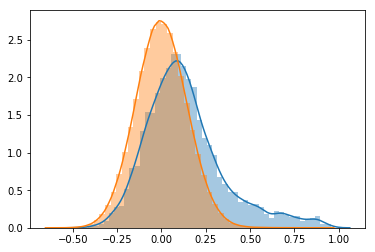

In [23]:
ranks_val_rawGE_chemprop_all, ranks_val_rawGE_chemprop_out = cca_cor(ncomp = 50,
                                                                       embeds_ge_train=gex_raw_train[:,-978:],
                                                                       embeds_ge_val=gex_raw[:,-978:],
                                                                       embeds_chem_train=chem_embeddings_chemprop_train,
                                                                       embeds_chem_val=chem_embeddings_chemprop)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 985.000    MRR: 0.032    H@10: 0.072    H@100: 0.209    H@500: 0.383
Val (In Train):         median_rank: 882.500    MRR: 0.037    H@10: 0.085    H@100: 0.234    H@500: 0.410
Val (Not in Train):     median_rank: 1352.000    MRR: 0.007    H@10: 0.012    H@100: 0.095    H@500: 0.260
Val (No train, limited):median_rank: 280.000    MRR: 0.024    H@10: 0.046    H@100: 0.244    H@500: 0.712
Average correlation between matched GE and Chem embeds (CCA):    0.1656111275858564
Average correlation between unmatched GE and Chem embeds (CAA):  -0.0012602705065241897
Difference:  0.16687139809238058



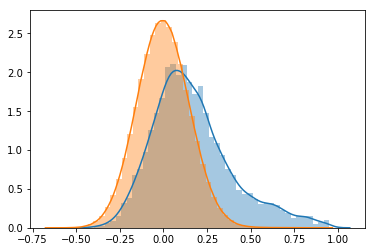

In [24]:
ranks_val_rawGE_chemEmbed_all, ranks_val_rawGE_chemEmbed_out = cca_cor(ncomp = 50,
        embeds_ge_train=gex_raw_train[:,-978:],
        embeds_ge_val=gex_raw[:,-978:])

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 1044.000    MRR: 0.019    H@10: 0.043    H@100: 0.157    H@500: 0.354
Val (In Train):         median_rank: 855.000    MRR: 0.022    H@10: 0.051    H@100: 0.181    H@500: 0.399
Val (Not in Train):     median_rank: 1947.000    MRR: 0.005    H@10: 0.008    H@100: 0.049    H@500: 0.146
Val (No train, limited):median_rank: 373.000    MRR: 0.015    H@10: 0.025    H@100: 0.152    H@500: 0.645
Average correlation between matched GE and Chem embeds (CCA):    0.15262623209570209
Average correlation between unmatched GE and Chem embeds (CAA):  0.007257854997378818
Difference:  0.14536837709832326



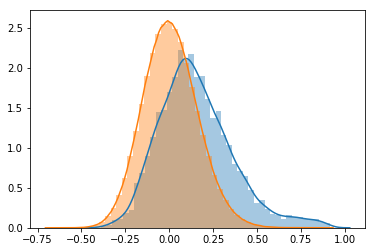

In [21]:
ranks_val_geEmbed_fps_all, ranks_val_geEmbed_fps_out = cca_cor(ncomp = 50,
                                                               embeds_chem_train=fingerprints_train,
                                                               embeds_chem_val=fingerprints)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 637.000    MRR: 0.030    H@10: 0.068    H@100: 0.214    H@500: 0.449
Val (In Train):         median_rank: 514.000    MRR: 0.035    H@10: 0.080    H@100: 0.242    H@500: 0.494
Val (Not in Train):     median_rank: 1411.000    MRR: 0.005    H@10: 0.011    H@100: 0.086    H@500: 0.244
Val (No train, limited):median_rank: 288.500    MRR: 0.025    H@10: 0.045    H@100: 0.270    H@500: 0.710
Average correlation between matched GE and Chem embeds (CCA):    0.21516560011267058
Average correlation between unmatched GE and Chem embeds (CAA):  0.0111299085462645
Difference:  0.20403569156640608



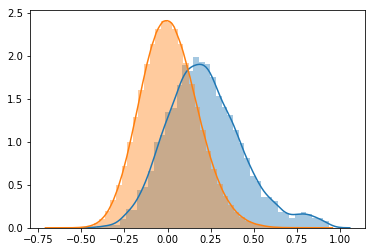

In [22]:
ranks_val_geEmbed_chemprop_all, ranks_val_geEmbed_chemprop_out = cca_cor(ncomp = 50,
                                                               embeds_chem_train=chem_embeddings_chemprop_train,
                                                               embeds_chem_val=chem_embeddings_chemprop)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 349.000    MRR: 0.045    H@10: 0.098    H@100: 0.294    H@500: 0.579
Val (In Train):         median_rank: 265.000    MRR: 0.053    H@10: 0.115    H@100: 0.335    H@500: 0.643
Val (Not in Train):     median_rank: 1065.000    MRR: 0.006    H@10: 0.017    H@100: 0.104    H@500: 0.281
Val (No train, limited):median_rank: 260.000    MRR: 0.026    H@10: 0.056    H@100: 0.259    H@500: 0.706
Average correlation between matched GE and Chem embeds (CCA):    0.3700051790815024
Average correlation between unmatched GE and Chem embeds (CAA):  0.027932963299468077
Difference:  0.3420722157820343



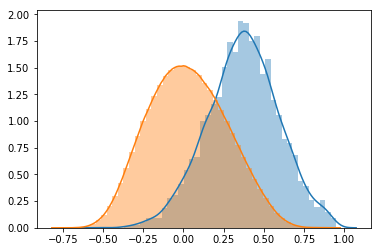

In [20]:
ranks_val_cca_all, ranks_val_cca_out = cca_cor(50)

## Plots

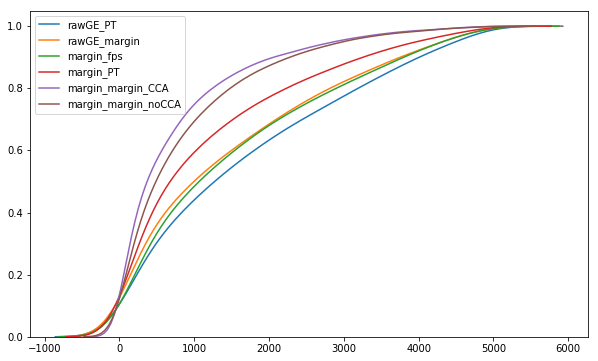

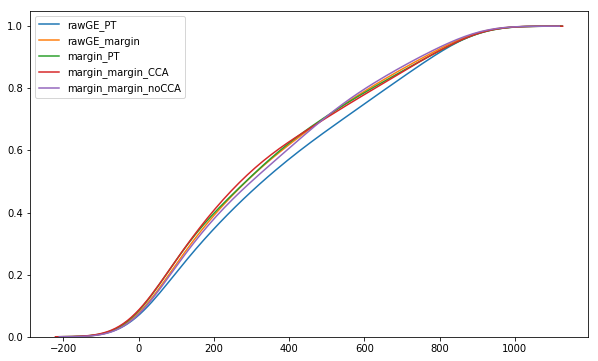

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
#sns.kdeplot(ranks_val_rawGE_fps_all, cumulative=True, label = 'rawGE_fps')
sns.kdeplot(ranks_val_rawGE_chemprop_all, cumulative=True, label = 'rawGE_PT')
sns.kdeplot(ranks_val_rawGE_chemEmbed_all, cumulative=True, label = 'rawGE_margin')
sns.kdeplot(ranks_val_geEmbed_fps_all, cumulative=True, label = "margin_fps")
sns.kdeplot(ranks_val_geEmbed_chemprop_all, cumulative=True, label = "margin_PT")
sns.kdeplot(ranks_val_cca_all, cumulative=True, label = "margin_margin_CCA")
sns.kdeplot(ranks_val_orig_all, cumulative=True, label = "margin_margin_noCCA")
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
#sns.kdeplot(ranks_val_rawGE_fps_out, cumulative=True, label = 'rawGE_fps')
sns.kdeplot(ranks_val_rawGE_chemprop_out, cumulative=True, label = 'rawGE_PT')
sns.kdeplot(ranks_val_rawGE_chemEmbed_out, cumulative=True, label = 'rawGE_margin')
#sns.kdeplot(ranks_val_geEmbed_fps_out, cumulative=True, label = "margin_fps")
sns.kdeplot(ranks_val_geEmbed_chemprop_out, cumulative=True, label = "margin_PT")
sns.kdeplot(ranks_val_cca_out, cumulative=True, label = "margin_margin_CCA")
sns.kdeplot(ranks_val_orig_out, cumulative=True, label = "margin_margin_noCCA")
plt.show()

In [29]:
5

5